# pix2pix: Image-to-image translation with a conditional GAN

This tutorial demonstrates how to build and train a conditional generative adversarial network (cGAN) called pix2pix that learns a mapping from input images to output images, as described in [Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004) by Isola et al. (2017). pix2pix is not application specific—it can be applied to a wide range of tasks, including synthesizing photos from label maps, generating colorized photos from black and white images, turning Google Maps photos into aerial images, and even transforming sketches into photos.

In this example, your network will generate images of building facades using the [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/) provided by the [Center for Machine Perception](http://cmp.felk.cvut.cz/) at the [Czech Technical University in Prague](https://www.cvut.cz/). To keep it short, you will use a [preprocessed copy](https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/) of this dataset created by the pix2pix authors.

In the pix2pix cGAN, you condition on input images and generate corresponding output images. cGANs were first proposed in [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) (Mirza and Osindero, 2014)

The architecture of your network will contain:

- A generator with a [U-Net](https://arxiv.org/abs/1505.04597)-based architecture.
- A discriminator represented by a convolutional PatchGAN classifier (proposed in the [pix2pix paper](https://arxiv.org/abs/1611.07004)).

Note that each epoch can take around 15 seconds on a single V100 GPU.

Below are some examples of the output generated by the pix2pix cGAN after training for 200 epochs on the facades dataset (80k steps).

![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png)
![sample output_2](https://www.tensorflow.org/images/gan/pix2pix_2.png)

## Import TensorFlow and other libraries

In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

2025-10-19 21:22:38.209067: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-19 21:22:38.280595: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-19 21:22:39.818386: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load the dataset

Download the CMP Facade Database data (30MB). Additional datasets are available in the same format [here](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/). In Colab you can select other datasets from the drop-down menu. Note that some of the other datasets are significantly larger (`edges2handbags` is 8GB in size). 

In [2]:
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]


In [3]:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip/dataset_name

In [4]:
list(PATH.parent.iterdir())

[PosixPath('/home/zkhechadoorian/.keras/datasets/facades_extracted/facades')]

Each original image is of size `256 x 512` containing two `256 x 256` images:

In [5]:
str(PATH)

'/home/zkhechadoorian/.keras/datasets/facades_extracted/facades'

2025-10-19 21:23:45.365765: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


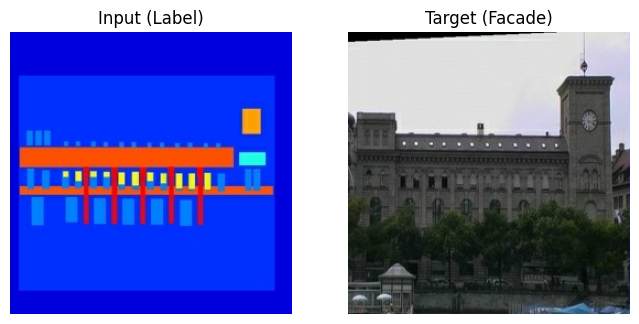

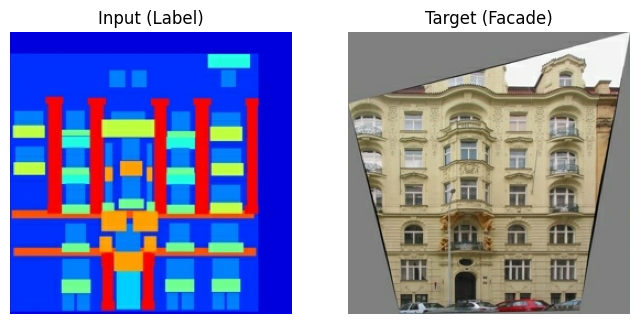

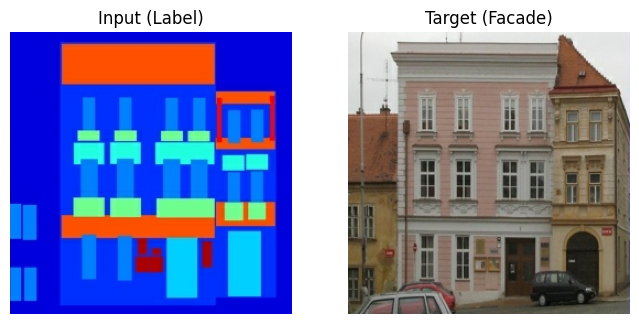

In [7]:
# Display a few random pairs from the training set
import matplotlib.pyplot as plt
import random
import glob

def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

sample_files = glob.glob(str(PATH / 'train/*.jpg'))
for i in range(3):
    img_path = random.choice(sample_files)
    inp, real = load(img_path)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.title("Input (Label)")
    plt.imshow(inp / 255.0)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title("Target (Facade)")
    plt.imshow(real / 255.0)
    plt.axis('off')
    plt.show()

In [8]:
sample_img_path = str(PATH / os.path.join('train', '1.jpg'))
print(sample_img_path)
sample_image = tf.io.read_file(sample_img_path)
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

/home/zkhechadoorian/.keras/datasets/facades_extracted/facades/train/1.jpg
(256, 512, 3)


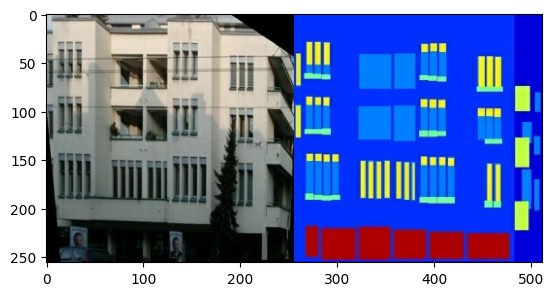

In [9]:
plt.figure()
plt.imshow(sample_image)

You need to separate real building facade images from the architecture label images—all of which will be of size `256 x 256`.

Define a function that loads image files and outputs two image tensors:

In [10]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

Plot a sample of the input (architecture label image) and real (building facade photo) images:

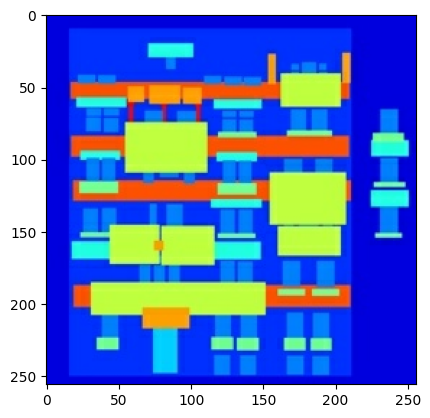

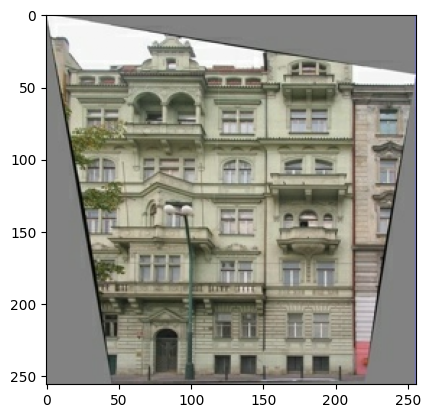

In [11]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004), you need to apply random jittering and mirroring to preprocess the training set.

Define several functions that:

1. Resize each `256 x 256` image to a larger height and width—`286 x 286`.
2. Randomly crop it back to `256 x 256`.
3. Randomly flip the image horizontally i.e., left to right (random mirroring).
4. Normalize the images to the `[-1, 1]` range.

In [12]:
import glob
print("Train images:", len(glob.glob(str(PATH / 'train/*.jpg'))))
print("Test images:", len(glob.glob(str(PATH / 'test/*.jpg'))))

Train images: 400
Test images: 106


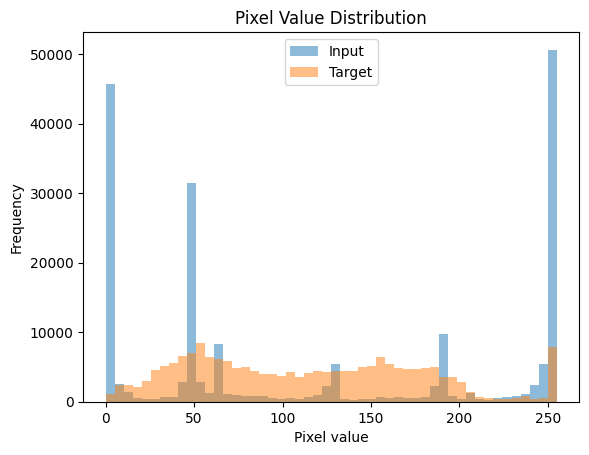

In [13]:
inp, real = load(random.choice(sample_files))
plt.hist(inp.numpy().flatten(), bins=50, alpha=0.5, label='Input')
plt.hist(real.numpy().flatten(), bins=50, alpha=0.5, label='Target')
plt.legend()
plt.title("Pixel Value Distribution")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

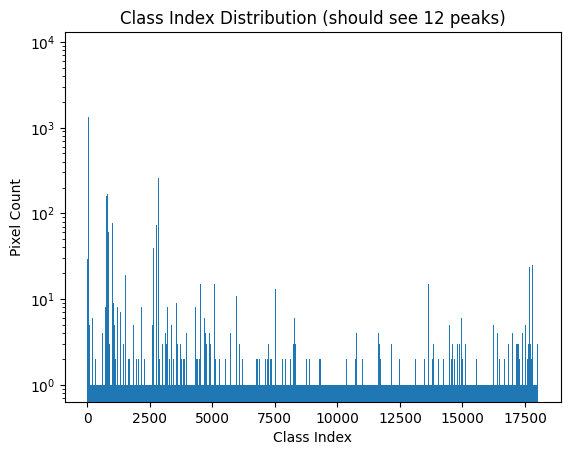

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Load a label image (input)
inp, _ = load(str(PATH / 'train/100.jpg'))
inp_uint8 = tf.cast(inp, tf.uint8).numpy()

# Reshape to (N, 3) and find unique colors
colors = inp_uint8.reshape(-1, 3)
unique_colors, class_indices = np.unique(colors, axis=0, return_inverse=True)

# Plot histogram of class indices
plt.hist(class_indices, bins=len(unique_colors))
plt.title("Class Index Distribution (should see 12 peaks)")
plt.xlabel("Class Index")
plt.ylabel("Pixel Count")
# make y log scale
plt.yscale('log')
plt.show()

**Jittering in pix2pix**

Jittering is a data augmentation technique used in pix2pix to improve the robustness and generalization of the model. It involves randomly resizing the input images to a slightly larger size (e.g., from 256×256 to 286×286), then randomly cropping them back to the original size (256×256), and randomly flipping them horizontally.

This process helps the model learn to handle small spatial variations and prevents overfitting by exposing it to more diverse training examples. Jittering is especially important in image-to-image translation tasks, where the model needs to generalize well to unseen data and not just memorize the training set.

In [15]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [16]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [17]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [18]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [19]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5: # half the time, a random mirroring will be applied
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

You can inspect some of the preprocessed output:

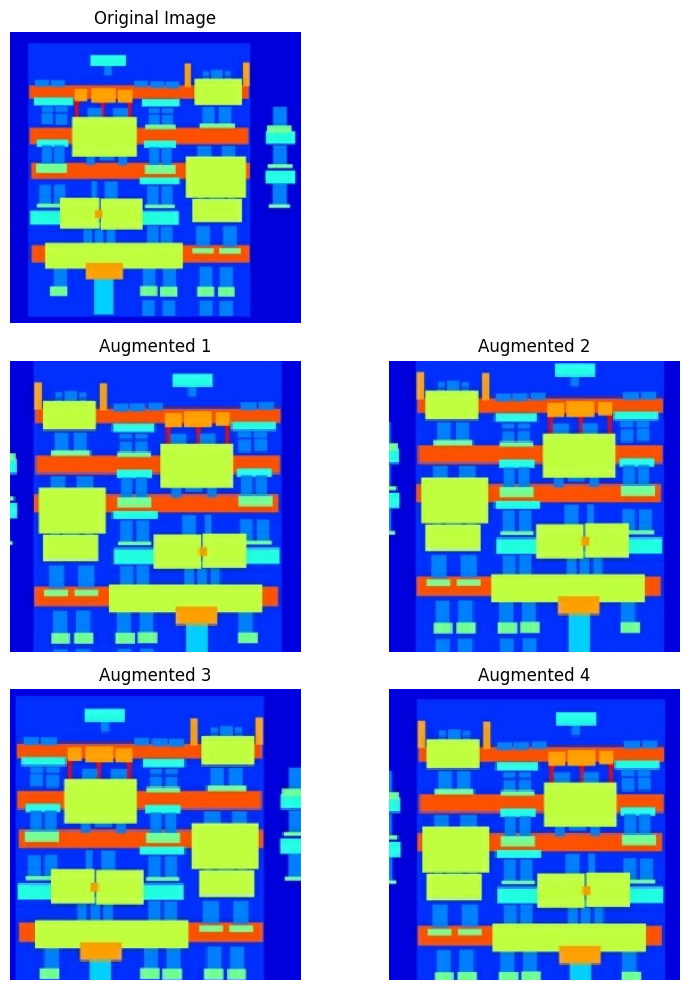

In [20]:
plt.figure(figsize=(8, 10))

# Show the original image at the top (full width)
plt.subplot(3, 2, 1)
plt.imshow(inp / 255.0)
plt.title("Original Image")
plt.axis('off')

# Show 4 augmented images in a 2x2 grid below
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(3, 2, i + 3)  # positions 3, 4, 5, 6
    plt.imshow(rj_inp / 255.0)
    plt.title(f"Augmented {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Having checked that the loading and preprocessing works, let's define a couple of helper functions that load and preprocess the training and test sets:

In [21]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [22]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Build an input pipeline with `tf.data`

In [23]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [24]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the generator

The generator of your pix2pix cGAN is a _modified_ [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the [Image segmentation](../images/segmentation.ipynb) tutorial and on the [U-Net project website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).)

- Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
- Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

Define the downsampler (encoder):

In [25]:
OUTPUT_CHANNELS = 3 # number of channels in the output image (RGB)

In [26]:
def downsample(filters, size, apply_batchnorm=True):
  # Initialize the weights with a normal distribution
  initializer = tf.random_normal_initializer(0., 0.02)

  # Create a Sequential model
  result = tf.keras.Sequential()
  # Add a Conv2D layer with the given number of filters and kernel size
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  # Optionally add BatchNormalization for faster and more stable training
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  # Add LeakyReLU activation for non-linearity
  result.add(tf.keras.layers.LeakyReLU())

  return result

In [27]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


Define the upsampler (decoder):

In [28]:
def upsample(filters, size, apply_dropout=False):
  # Initialize the weights with a normal distribution
  initializer = tf.random_normal_initializer(0., 0.02)

  # Create a Sequential model for the upsampling block
  result = tf.keras.Sequential()
  # Add a Conv2DTranspose layer to upsample the input
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  # Add BatchNormalization for faster and more stable training
  result.add(tf.keras.layers.BatchNormalization())

  # Optionally add Dropout for regularization (only in first 3 blocks of decoder)
  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  # Add ReLU activation for non-linearity
  result.add(tf.keras.layers.ReLU())

  return result

In [29]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


Define the generator with the downsampler and the upsampler:

In [30]:
def Generator():
  # Define the input layer with shape (256, 256, 3)
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  # Create the encoder (downsampling stack) using downsample blocks
  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # First block, no batchnorm
    downsample(128, 4),  # Second block
    downsample(256, 4),  # Third block
    downsample(512, 4),  # Fourth block
    downsample(512, 4),  # Fifth block
    downsample(512, 4),  # Sixth block
    downsample(512, 4),  # Seventh block
    downsample(512, 4),  # Eighth block
  ]

  # Create the decoder (upsampling stack) using upsample blocks
  up_stack = [
    upsample(512, 4, apply_dropout=True),  # First block, with dropout
    upsample(512, 4, apply_dropout=True),  # Second block, with dropout
    upsample(512, 4, apply_dropout=True),  # Third block, with dropout
    upsample(512, 4),  # Fourth block
    upsample(256, 4),  # Fifth block
    upsample(128, 4),  # Sixth block
    upsample(64, 4),   # Seventh block
  ]

  # Initialize the weights for the last layer
  initializer = tf.random_normal_initializer(0., 0.02)
  # Define the last layer to get the output image with tanh activation
  last = tf.keras.layers.Conv2DTranspose(
      OUTPUT_CHANNELS, 4,
      strides=2,
      padding='same',
      kernel_initializer=initializer,
      activation='tanh')  # Output shape: (batch_size, 256, 256, 3)

  x = inputs  # Start with the input

  # Downsampling through the encoder, saving skip connections
  skips = []
  for down in down_stack:
    x = down(x)      # Apply downsampling block
    skips.append(x)  # Save output for skip connection

  # Reverse all but the last skip for use in upsampling
  skips = reversed(skips[:-1])

  # Upsampling and adding skip connections from encoder
  for up, skip in zip(up_stack, skips):
    x = up(x)                              # Apply upsampling block
    x = tf.keras.layers.Concatenate()([x, skip])  # Add skip connection

  x = last(x)  # Apply the last layer to get the final output

  # Return the Keras Model
  return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

In [32]:
generator = Generator()
tf.keras.utils.plot_model(generator, to_file='model.png', show_shapes=True, dpi=64)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [33]:
import os
print(os.getcwd())

/home/zkhechadoorian/GANs_architecture/notebooks


Test the generator:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


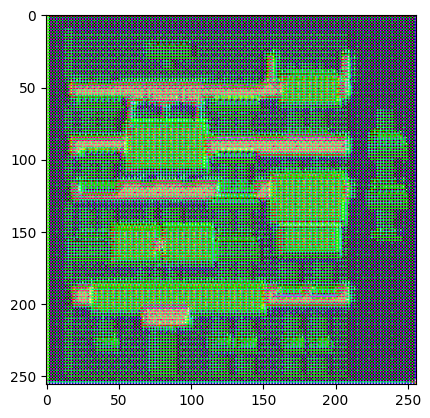

In [34]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [35]:
LAMBDA = 100

### Why BinaryCrossentropy Loss is Needed in pix2pix

In pix2pix, a conditional GAN (cGAN) is used for image-to-image translation. The GAN framework consists of two neural networks: the **generator** and the **discriminator**. The generator tries to produce realistic images from input data, while the discriminator tries to distinguish between real images and those produced by the generator.

#### BinaryCrossentropy Loss

The **BinaryCrossentropy** loss is used because the discriminator's task is a binary classification: it must decide whether each image patch is real (from the dataset) or fake (generated). In pix2pix, the discriminator is a PatchGAN, which outputs a matrix where each element corresponds to a small patch of the input image. Each patch is classified as real or fake, so BinaryCrossentropy is applied to every patch.

#### Does the Discriminator Classify the Whole Image or Each Pixel?

The discriminator does **not** classify the whole image as real or fake, nor does it classify each pixel individually. Instead, it classifies overlapping patches (e.g., 70x70 pixels) within the image. The output is a grid (e.g., 30x30) of predictions, each representing the probability that a corresponding patch is real. This encourages the generator to produce realistic details at the patch level.

#### Generator Loss

The generator's loss has two components:
- **GAN loss**: Encourages the generator to produce images that the discriminator classifies as real (for all patches). This is computed as BinaryCrossentropy between an array of ones (targeting "real") and the discriminator's output for generated images.
- **L1 loss**: Measures the mean absolute error between the generated image and the target image, encouraging structural similarity.

The total generator loss is:


In [36]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [37]:
def generator_loss(disc_generated_output, gen_output, target):
  # GAN loss: how well the generator fools the discriminator
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # L1 loss: mean absolute error between generated image and target image
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  # Total generator loss: GAN loss + weighted L1 loss
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  # Return all losses for logging and optimization
  return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs: 
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

Let's define the discriminator:

In [38]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  # Input layers for the input image and the target image
  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  # Concatenate the input and target images along the channel axis
  # Shape: (batch_size, 256, 256, 6)
  x = tf.keras.layers.concatenate([inp, tar])

  # First downsampling block: Conv2D -> (optional) BatchNorm -> LeakyReLU
  # Reduces spatial size, increases channels
  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)

  # Second downsampling block
  down2 = downsample(128, 4)(down1)    # (batch_size, 64, 64, 128)

  # Third downsampling block
  down3 = downsample(256, 4)(down2)    # (batch_size, 32, 32, 256)

  # Zero padding to increase spatial dimensions
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)

  # Convolution to extract features, stride=1 keeps spatial size
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  # Batch normalization for stable training
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  # LeakyReLU activation for non-linearity
  # LeakyReLU is used instead of ReLU to avoid the "dying ReLU" problem,
  # where neurons can become inactive and only output zero. LeakyReLU allows
  # a small, non-zero gradient when the unit is not active, which helps gradients
  # flow through the network and improves training stability for GANs.
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  # Zero padding before the last layer
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  # Final convolution: outputs a single-channel prediction map
  # Each value represents real/fake for a patch
  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  # Return the Keras Model
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

In [39]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Test the discriminator:

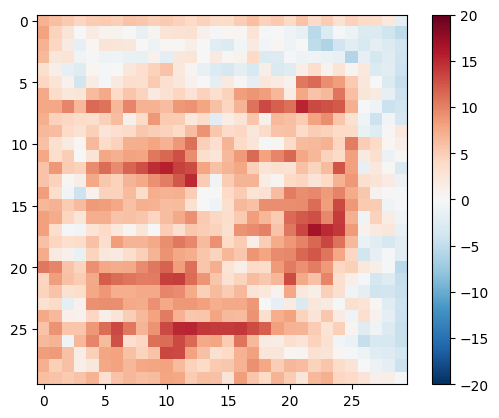

In [40]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

This visualization shows the output of the PatchGAN discriminator for a generated image.

- `disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)`  
  This line passes the input image (`inp`) and the generated image (`gen_output`) to the discriminator. The discriminator outputs a 2D grid (typically 30x30) where each value represents the discriminator's confidence that a local patch in the image is "real" (from the dataset) or "fake" (generated).

- `plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')`  
  This displays the discriminator's output grid as an image. The color indicates the confidence for each patch:  
  - Red/blue colors (from the `RdBu_r` colormap) show high/low confidence values.
  - The range `vmin=-20, vmax=20` helps visualize the logits (raw outputs before sigmoid activation).

- `plt.colorbar()`  
  Adds a color scale to interpret the confidence values.

**In summary:**  
This plot helps you see which regions of the generated image the discriminator considers real or fake. High values (red) mean the discriminator thinks the patch is real; low values (blue) mean it thinks the patch is fake.

/tmp/ipykernel_3987840/692882437.py:22: UserWarning: Adding colorbar to a different Figure <Figure size 1500x500 with 6 Axes> than <Figure size 1500x500 with 4 Axes> which fig.colorbar is called on.
  plt.colorbar(im2, fraction=0.046, pad=0.04)


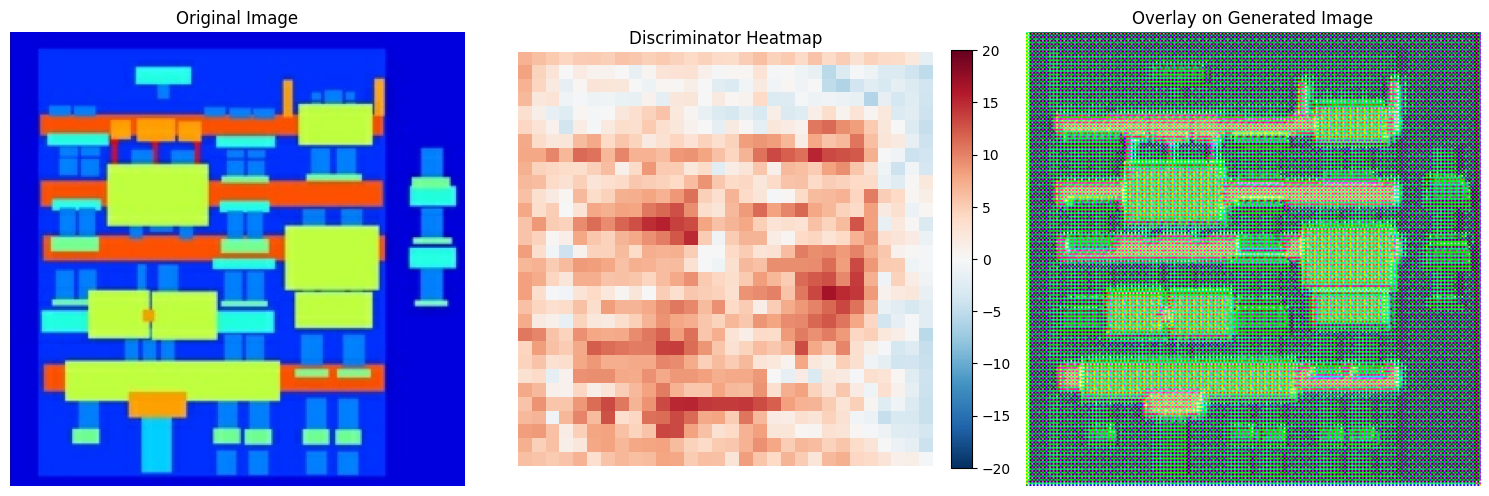

In [56]:
plt.figure(figsize=(15, 5))

# 1. Original image
plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title("Original Image")
plt.axis('off')

# 2. Discriminator heatmap
plt.subplot(1, 3, 2)
im1 = plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.title("Discriminator Heatmap")
plt.axis('off')
plt.colorbar(im1, fraction=0.046, pad=0.04)

# 3. Overlay on generated image
plt.subplot(1, 3, 3)
plt.imshow(gen_output[0, ...] * 0.5 + 0.5)  # Scale to [0, 1] for display
#im2 = plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r', alpha=0.5)
plt.title("Overlay on Generated Image")
plt.axis('off')
plt.colorbar(im2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### Define the discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [41]:
def discriminator_loss(disc_real_output, disc_generated_output):
  # Calculate loss for real images (should be classified as real/ones)
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  # Calculate loss for generated images (should be classified as fake/zeros)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  # Total discriminator loss is the sum of real and generated losses
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the optimizers and a checkpoint-saver


In [42]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [43]:
# Directory where checkpoints will be saved during training
checkpoint_dir = './training_checkpoints'

# Prefix for checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Create a TensorFlow checkpoint object to manage saving and restoring models and optimizers
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,      # Save generator optimizer state
    discriminator_optimizer=discriminator_optimizer,  # Save discriminator optimizer state
    generator=generator,                         # Save generator model weights
    discriminator=discriminator                  # Save discriminator model weights
)

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

Note: The `training=True` is intentional here since you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [57]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Test the function:

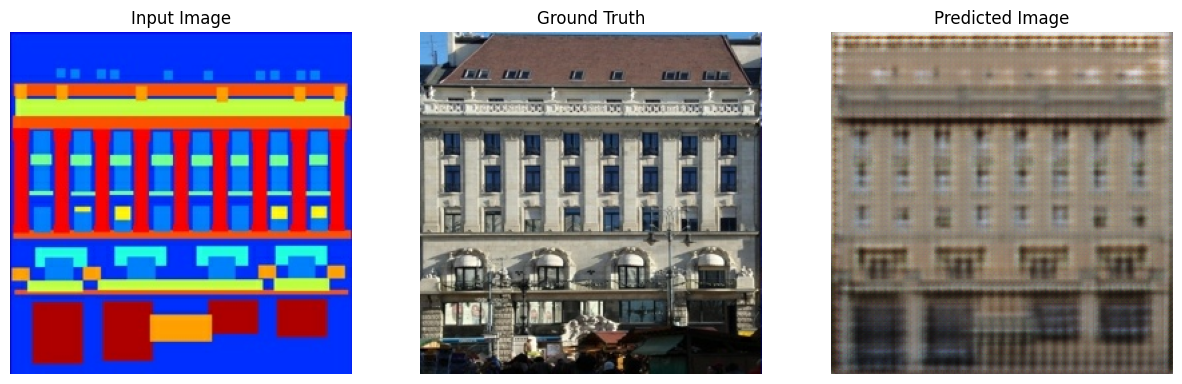

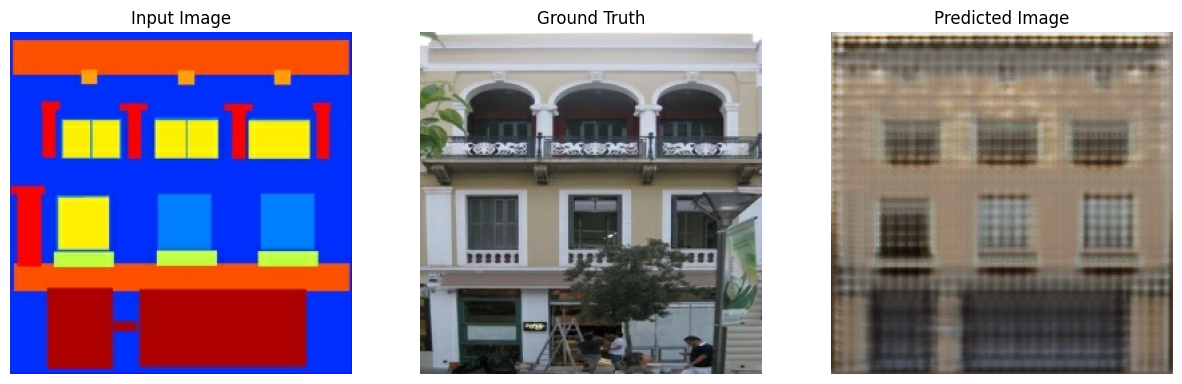

2025-10-19 21:38:58.195510: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [59]:
for example_input, example_target in test_dataset.take(2):
  generate_images(generator, example_input, example_target)

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [60]:
# Set the directory for TensorBoard logs
log_dir = "logs/"

# Create a summary writer for TensorBoard.
# The logs will be saved in a subdirectory named with the current date and time.
# This allows you to visualize training metrics in TensorBoard.
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [61]:
@tf.function
def train_step(input_image, target, step):
  # Record operations for automatic differentiation for generator and discriminator
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Generate an output image from the input using the generator (forward pass)
    gen_output = generator(input_image, training=True)

    # Get discriminator's output for real image pairs (input and ground truth)
    disc_real_output = discriminator([input_image, target], training=True)
    # Get discriminator's output for fake image pairs (input and generated output)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    # Compute generator losses: total loss, GAN loss, and L1 loss
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
        disc_generated_output, gen_output, target)
    # Compute discriminator loss (real vs. fake)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  # Calculate gradients of generator loss w.r.t. generator's trainable variables
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  # Calculate gradients of discriminator loss w.r.t. discriminator's trainable variables
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  # Apply gradients to update generator weights
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  # Apply gradients to update discriminator weights
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  # Write loss values to TensorBoard for visualization
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [62]:
def fit(train_ds, test_ds, steps):
  # Get one example input and target from the test dataset for visualization
  example_input, example_target = next(iter(test_ds.take(1)))
  # Record the start time for timing training steps
  start = time.time()

  # Iterate over the training dataset for the specified number of steps
  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    # Every 1000 steps, clear the output and display progress
    if (step) % 1000 == 0:
      # Clear previous output in the notebook for a cleaner display
      display.clear_output(wait=True)

      # If not the first step, print the time taken for the last 1000 steps
      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      # Reset the timer for the next 1000 steps
      start = time.time()

      # Generate and display images using the generator for visual progress
      generate_images(generator, example_input, example_target)
      # Print the current step in thousands (k)
      print(f"Step: {step//1000}k")

    # Perform one training step (update generator and discriminator)
    train_step(input_image, target, step)

    # Print a dot every 10 steps to indicate progress
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    # Save a checkpoint every 5000 steps to preserve model state
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

Launch the TensorBoard viewer (Sorry, this doesn't
display on tensorflow.org):

In [63]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3988144), started 0:14:08 ago. (Use '!kill 3988144' to kill it.)

Finally, run the training loop:

Time taken for 1000 steps: 205.97 sec



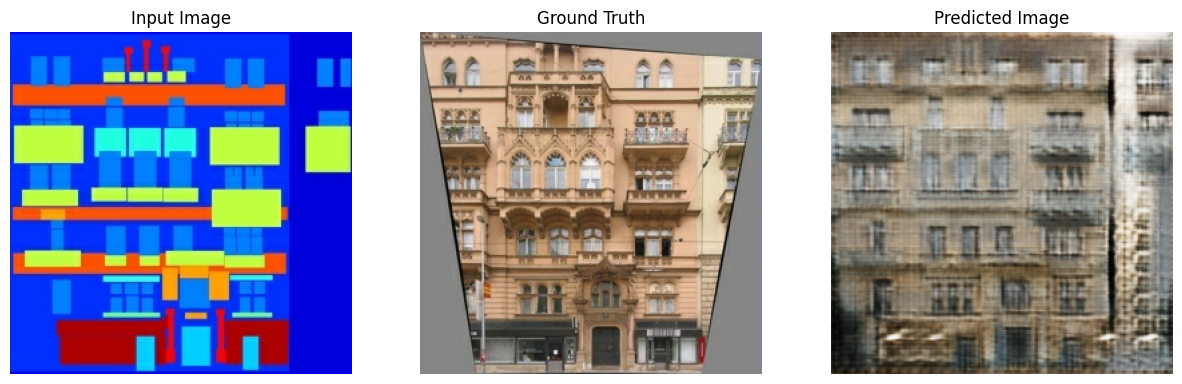

Step: 9k
....................................................................................................

In [65]:
fit(train_dataset, test_dataset, steps=10000)

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [66]:
!ls {checkpoint_dir}

checkpoint		    ckpt-1.index		ckpt-2.index
ckpt-1.data-00000-of-00001  ckpt-2.data-00000-of-00001


In [67]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

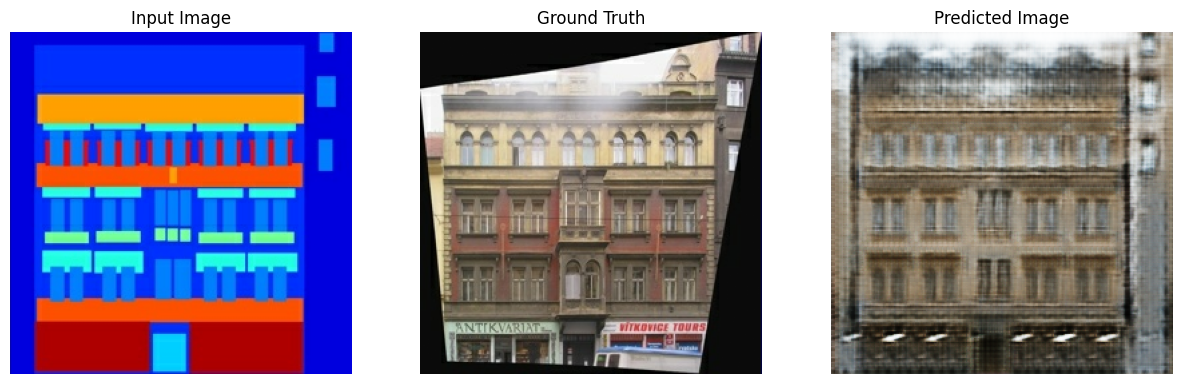

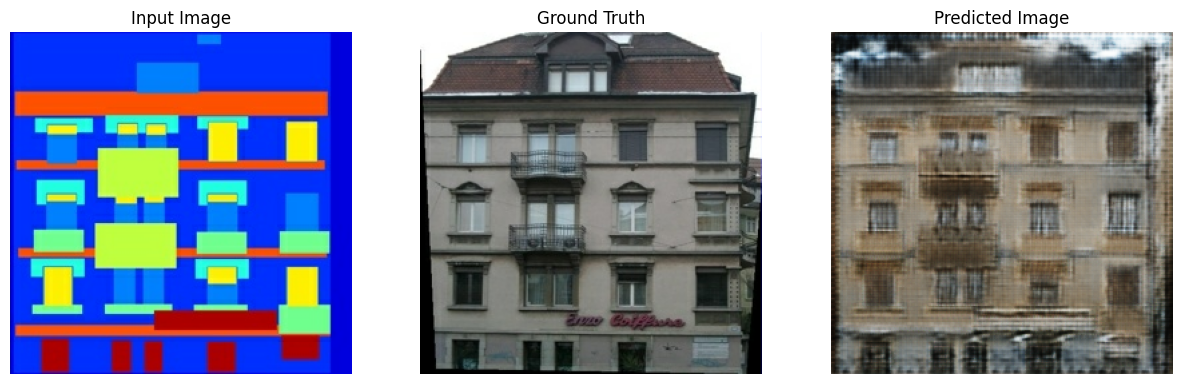

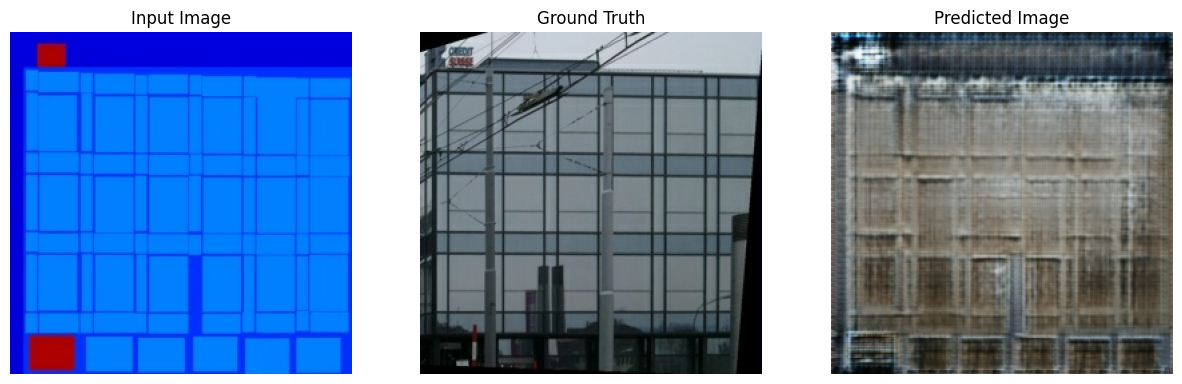

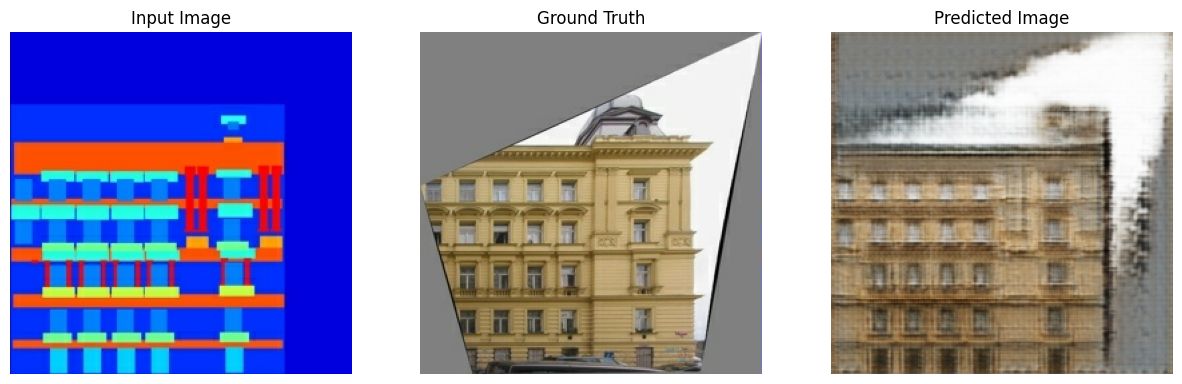

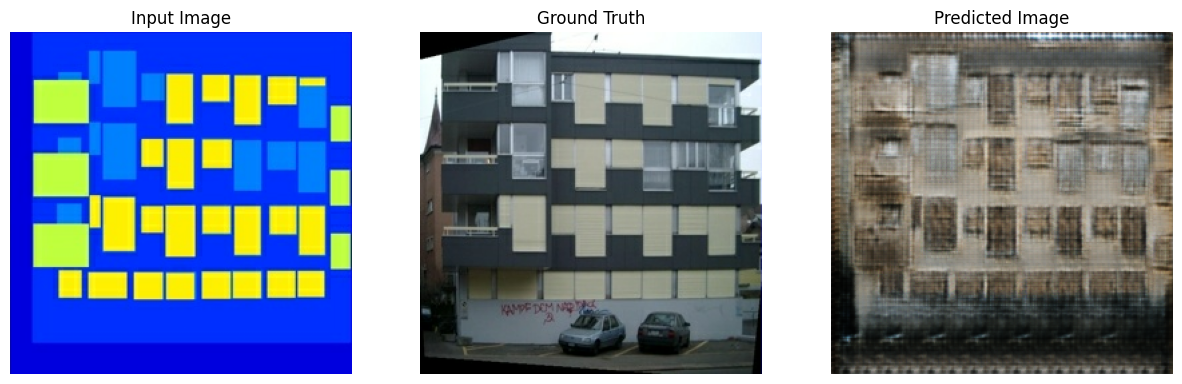

In [68]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3975990), started 0:03:37 ago. (Use '!kill 3975990' to kill it.)